In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loader and Quality Check

In [25]:
import pandas as pd

def load_and_extract_ticker(csv_path, ticker):
    # Load with two header rows
    df = pd.read_csv(csv_path, header=[0, 1])

    # Flatten MultiIndex header
    df.columns = [
        f"{c0}_{c1}" if pd.notna(c1) and c1 != "" else c0
        for c0, c1 in df.columns
    ]

    # Drop the first two junk rows (Price / Datetime)
    df = df.drop([0, 1]).reset_index(drop=True)

    # Extract datetime column
    df['Datetime'] = pd.to_datetime(df['Ticker_Price'])

    # Remove leftover junk Ticker_* columns
    df = df.drop(columns=['Ticker_Price'])

    # Build expected ticker column names
    col_map = {
        f"{ticker}_Open": "Open",
        f"{ticker}_High": "High",
        f"{ticker}_Low": "Low",
        f"{ticker}_Close": "Close",
        f"{ticker}_Volume": "Volume"
    }

    # Extract and rename
    ticker_df = df[['Datetime'] + list(col_map.keys())].rename(columns=col_map)

    return ticker_df


In [26]:
aapl_df = load_and_extract_ticker("equities_intraday_1h_1year.csv", "AAPL")
aapl_df.head()


,Datetime,Open,High,Low,Close,Volume
0,2024-01-02 15:30:00+00:00,186.179993,186.904999,185.184296,186.804993,9010595.0
1,2024-01-02 16:30:00+00:00,186.800003,187.350006,186.570007,186.615005,6143754.0
2,2024-01-02 17:30:00+00:00,186.615005,187.039993,185.259995,185.294998,5381701.0
3,2024-01-02 18:30:00+00:00,185.289993,185.539993,184.229996,184.494995,7228643.0
4,2024-01-02 19:30:00+00:00,184.490005,184.679993,183.884995,184.419998,8238940.0


In [135]:
msft_df = load_and_extract_ticker("equities_intraday_1h_1year.csv", "MSFT")
msft_df.head()


,Datetime,Open,High,Low,Close,Volume
0,2024-01-02 15:30:00+00:00,368.250000,369.980011,367.000000,369.970001,2726569.0
1,2024-01-02 16:30:00+00:00,369.959991,371.359985,369.899994,370.476990,1957295.0
2,2024-01-02 17:30:00+00:00,370.474609,371.019989,369.140015,369.630005,1609221.0
3,2024-01-02 18:30:00+00:00,369.635010,370.200012,368.890015,369.549988,1243301.0
4,2024-01-02 19:30:00+00:00,369.540009,369.760010,368.285004,369.320007,1743397.0


In [144]:
amzn_df = load_and_extract_ticker("equities_intraday_1h_1year.csv", "AMZN")
amzn_df.head()


,Datetime,Open,High,Low,Close,Volume
0,2024-01-02 15:30:00+00:00,148.679993,149.990005,148.389999,149.960098,5385584.0
1,2024-01-02 16:30:00+00:00,149.964996,150.949997,149.860001,149.876602,4647258.0
2,2024-01-02 17:30:00+00:00,149.880005,150.149994,149.485001,149.840103,2779099.0
3,2024-01-02 18:30:00+00:00,149.845001,150.107498,149.149994,149.604996,2593717.0
4,2024-01-02 19:30:00+00:00,149.604996,149.829895,148.970001,149.315002,4052668.0


In [31]:
def full_quality_check(df):
    results = {}
    
    df = df.sort_values("Datetime")

    # 1. Basic metadata
    results["num_rows"] = len(df)
    results["date_range"] = (df["Datetime"].min(), df["Datetime"].max())

    # 2. Missing timestamps
    expected = pd.date_range(start=df["Datetime"].min(),
                             end=df["Datetime"].max(),
                             freq="1H",
                             tz="UTC")
    missing = expected.difference(df["Datetime"])
    results["expected_count"] = len(expected)
    results["actual_count"] = len(df)
    results["missing_timestamp_count"] = len(missing)

    # 3. Duplicate timestamps
    results["duplicate_timestamps"] = df["Datetime"].duplicated().sum()

    # 4. Invalid OHLC structure
    invalid_ohlc = df[
        (df["Low"] > df["Open"]) |
        (df["Low"] > df["Close"]) |
        (df["High"] < df["Open"]) |
        (df["High"] < df["Close"])
    ]
    results["invalid_ohlc_rows"] = len(invalid_ohlc)

    # 5. Zero or negative values
    price_cols = ["Open", "High", "Low", "Close"]
    results["zero_or_negative_prices"] = (df[price_cols] <= 0).sum().to_dict()

    # 6. Large price jumps (> 5%)
    df["pct_change"] = df["Close"].pct_change()
    jumps = df[df["pct_change"].abs() > 0.05]
    results["large_jumps"] = len(jumps)

    return results


In [33]:
full_quality_check(aapl_df)

C:\Users\15126\AppData\Local\Temp\ipykernel_25516\1235865634.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected = pd.date_range(start=df["Datetime"].min(),


{'num_rows': 1751,
 'date_range': (Timestamp('2024-01-02 15:30:00+0000', tz='UTC'),
  Timestamp('2024-12-31 20:30:00+0000', tz='UTC')),
 'expected_count': 8742,
 'actual_count': 1751,
 'missing_timestamp_count': 6991,
 'duplicate_timestamps': np.int64(0),
 'invalid_ohlc_rows': 0,
 'zero_or_negative_prices': {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0},
 'large_jumps': 2}

# AAPL Visualization

Text(0, 0.5, 'AAPL Close Price')

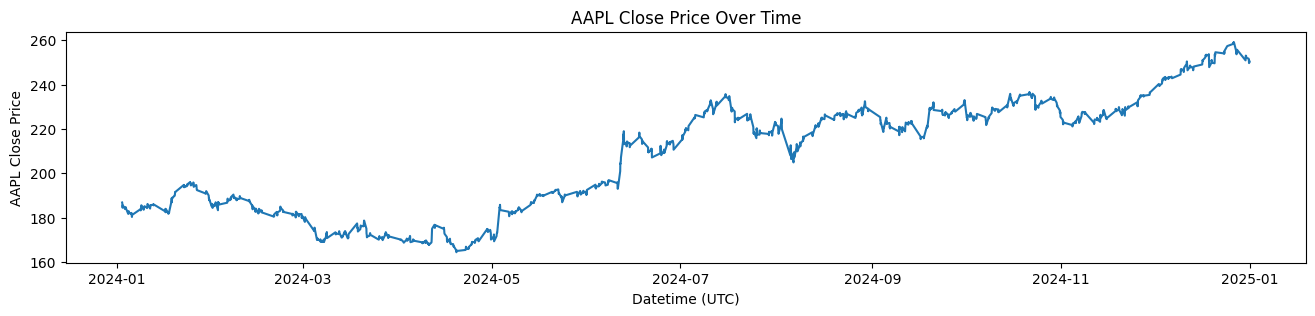

In [46]:
x = aapl_df['Datetime'].dt.tz_convert('UTC')
y = aapl_df['Close']
plt.figure(figsize=(16, 3))
plt.plot(x, y)
plt.title('AAPL Close Price Over Time')
plt.xlabel('Datetime (UTC)')
plt.ylabel('AAPL Close Price')

# Generating Signals

## Mean-Reversion Strategy

We measure how far the current price is from its moving average using:

$$
PercentageDeviation_t = \frac{Close_t - MA_t}{MA_t}
$$

---

## Trading Rules

Let $\tau$ be the threshold that determines when a deviation is large enough to trade.

1. **Buy (long = +1)** when:

$$
PercentageDeviation_t < -\tau
$$

2. **Sell / Short (–1)** when:

$$
PercentageDeviation_t > \tau
$$

3. **Hold (0)** when:

$$
-\tau \le PercentageDeviation_t \le \tau
$$

---

## Interpretation

- Negative deviation → buy zone  
- Positive deviation → sell zone  
- Only deviations larger than $\tau$ trigger trades


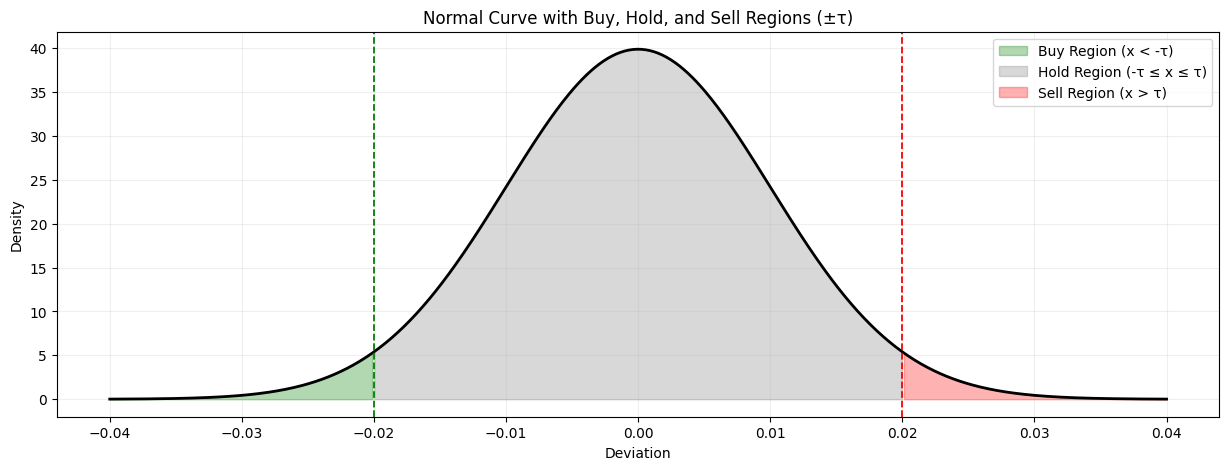

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mu, sigma = 0, 0.01
tau = 0.02

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 500)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(15,5))
plt.plot(x, y, color="black", linewidth=2)
plt.fill_between(x, y, where=(x < -tau), color="green", alpha=0.3, label="Buy Region (x < -τ)")
plt.fill_between(x, y, where=((x >= -tau) & (x <= tau)), color="gray", alpha=0.3, label="Hold Region (-τ ≤ x ≤ τ)")
plt.fill_between(x, y, where=(x > tau), color="red", alpha=0.3, label="Sell Region (x > τ)")
plt.axvline(-tau, color="green", linestyle="--", linewidth=1.3)
plt.axvline(tau, color="red", linestyle="--", linewidth=1.3)

plt.title("Normal Curve with Buy, Hold, and Sell Regions (±τ)")
plt.xlabel("Deviation")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


In [ ]:
from strategies import BuyLowSellHighStrategy
from backtester import Backtester

# Generate signals, here tau is 0.002
strategy = BuyLowSellHighStrategy(lookback=5, pct_threshold=0.002)
signals = strategy.generate_signals(aapl_df)
# Run backtest
bt = Backtester(signals)
results = bt.run()

## Equity Plot Compared to Buy and Hold

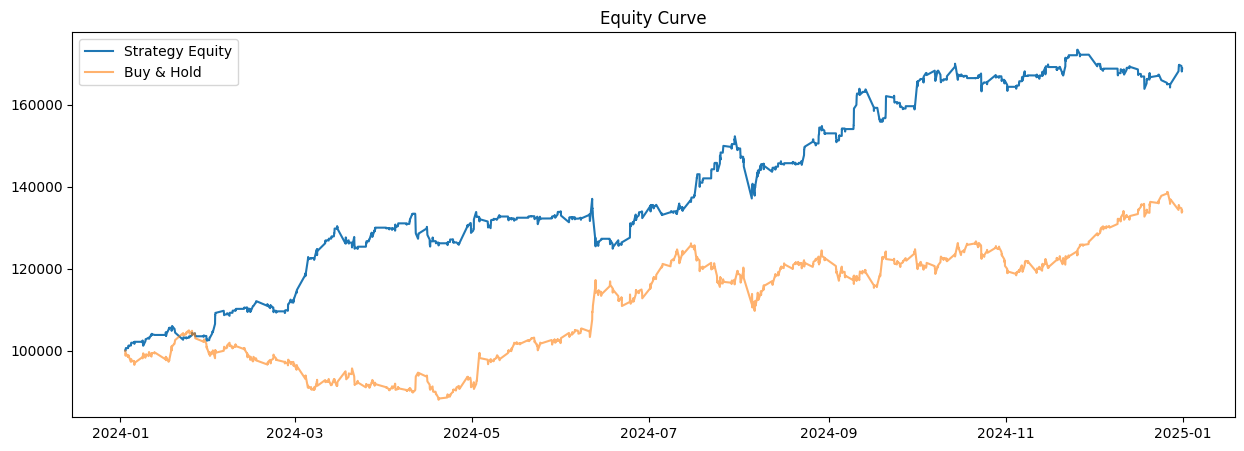

In [74]:
df_bt = results["df"]
plt.figure(figsize=(15,5))
plt.plot(df_bt["Datetime"], df_bt["equity"], label="Strategy Equity")
plt.plot(df_bt["Datetime"], df_bt["buy_hold"], label="Buy & Hold", alpha=0.6)
plt.title("Equity Curve")
plt.legend()
plt.show()


In [129]:
lookbacks = list(range(1, 13)) + [15, 20, 25, 30]

taus = [
    0.0001, 0.0002, 0.0003, 0.0005,
    0.001, 0.0015, 0.002,
    0.003, 0.004, 0.005
]


In [130]:
results_list = []
all_equity_curves = {}

for lb in lookbacks:
    for tau in taus:
        lb_int = int(lb)                     # ensure integer
        name = f"LB={lb_int}_TAU={tau}"      # consistent key format

        strategy = BuyLowSellHighStrategy(lookback=lb_int, pct_threshold=tau)
        signals = strategy.generate_signals(aapl_df)

        bt = Backtester(signals)
        res = bt.run()

        df_bt = res["df"]
        all_equity_curves[name] = df_bt[["Datetime", "equity"]]

        results_list.append({
            "lookback": lb_int,              # store as integer
            "tau": tau,
            "final_equity": res["final_equity"],
            "sharpe_ratio": res["sharpe_ratio"],
            "max_drawdown": res["max_drawdown"],
            "num_trades": res["trade_stats"]["num_trades"]
        })

grid_results = pd.DataFrame(results_list)


C:\Users\15126\AppData\Local\Temp\ipykernel_25516\2152449896.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


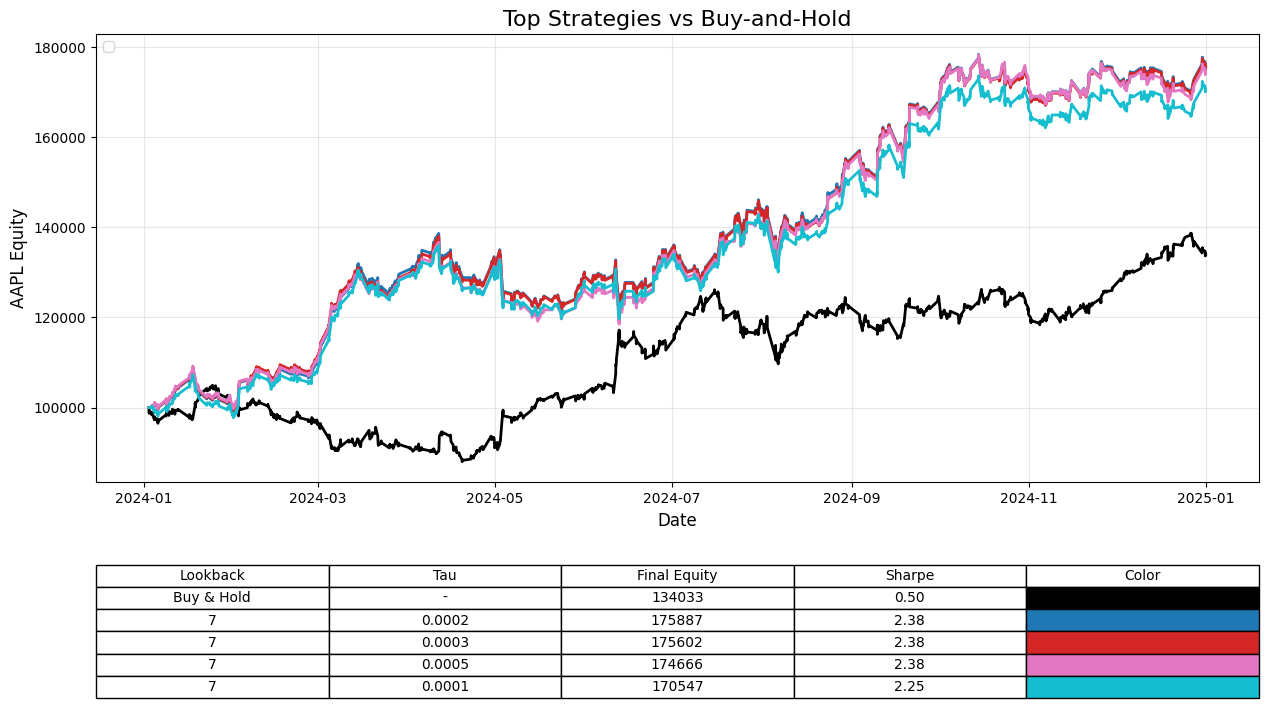

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

top_n = 4
top_strats = grid_results.sort_values("final_equity", ascending=False).head(top_n)

colors = plt.cm.tab10(np.linspace(0, 1, top_n))

fig, (ax, ax_table) = plt.subplots(
    2, 1,
    figsize=(15, 8),
    gridspec_kw={"height_ratios": [3, 1]}
)

# ---- TOP: EQUITY CURVES ----
ax.plot(
    df_bt["Datetime"],
    df_bt["buy_hold"],
    linewidth=2,
    color="black"
)

table_rows = []

# ---- BUY & HOLD ROW FIRST ----
bh_final = df_bt["buy_hold"].iloc[-1]
bh_returns = df_bt["buy_hold"].pct_change().dropna()
bh_sharpe = np.sqrt(252) * bh_returns.mean() / bh_returns.std()

table_rows.append([
    "Buy & Hold",
    "-",
    f"{bh_final:.0f}",
    f"{bh_sharpe:.2f}",
    ""
])

# ---- STRATEGY CURVES ----
for i, (_, row) in enumerate(top_strats.iterrows()):
    name = f"LB={int(row['lookback'])}_TAU={row['tau']}"
    df_curve = all_equity_curves[name]

    ax.plot(
        df_curve["Datetime"],
        df_curve["equity"],
        linewidth=2,
        color=colors[i]
    )

    table_rows.append([
        int(row["lookback"]),
        row["tau"],
        f"{row['final_equity']:.0f}",
        f"{row['sharpe_ratio']:.2f}",
        ""
    ])

ax.set_title("Top Strategies vs Buy-and-Hold", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("AAPL Equity", fontsize=12)
ax.grid(alpha=0.3)
ax.legend(loc="upper left")

# ---- BOTTOM: TABLE ----
ax_table.axis("off")

col_labels = ["Lookback", "Tau", "Final Equity", "Sharpe", "Color"]
table = ax_table.table(
    cellText=table_rows,
    colLabels=col_labels,
    cellLoc="center",
    loc="center"
)

# Color column
table[(1, 4)].set_facecolor("black")
for i in range(top_n):
    table[(i + 2, 4)].set_facecolor(colors[i])

table.scale(1, 1.25)

# ---- CRITICAL FIX: MANUAL SPACING ----
fig.subplots_adjust(
    top=0.92,
    bottom=0.08,
    hspace=0.25   # <-- THIS prevents overlap
)

plt.show()



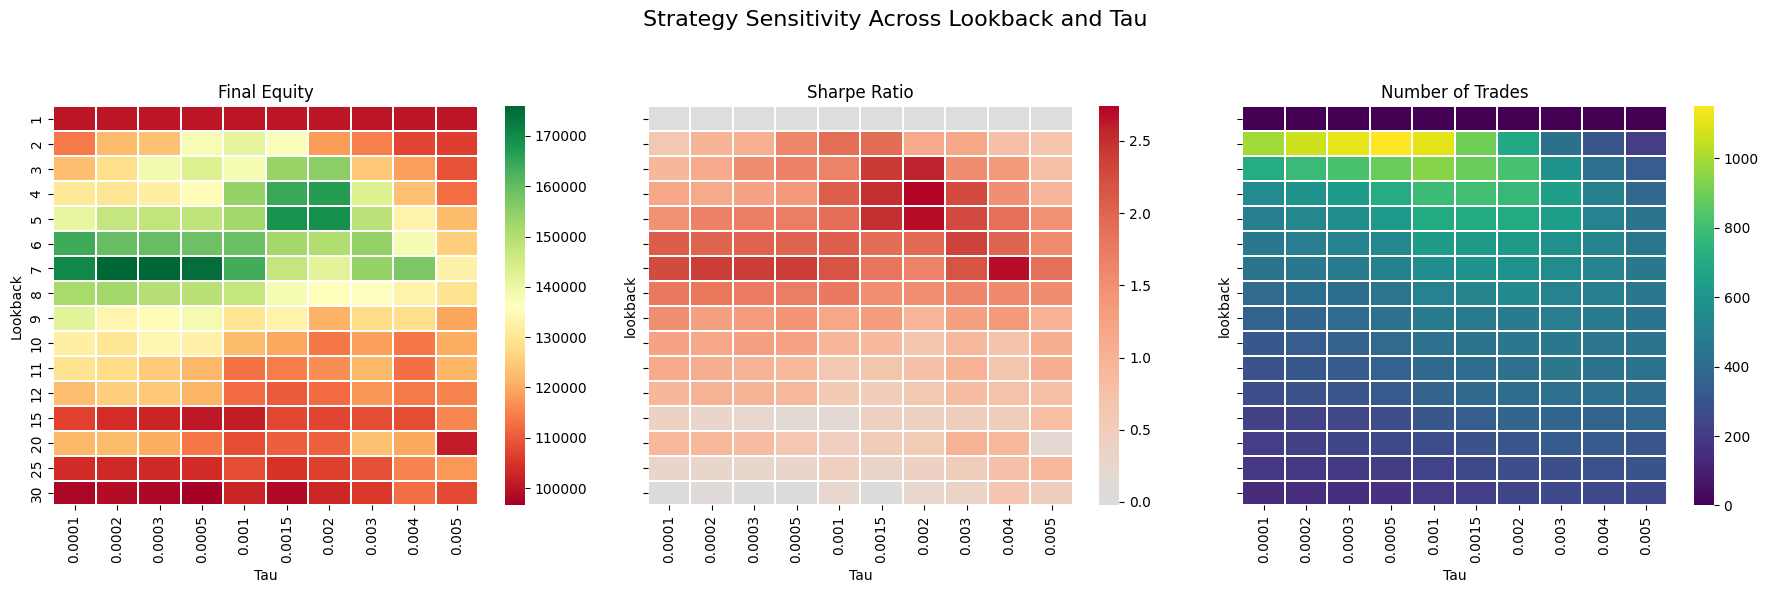

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot data
equity_map = grid_results.pivot(
    index="lookback", columns="tau", values="final_equity"
)

sharpe_map = grid_results.pivot(
    index="lookback", columns="tau", values="sharpe_ratio"
)

trades_map = grid_results.pivot(
    index="lookback", columns="tau", values="num_trades"
)

# Create subplots
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    sharey=True
)

# --- Final Equity ---
sns.heatmap(
    equity_map,
    ax=axes[0],
    cmap="RdYlGn",
    linewidths=0.3,
    cbar=True
)
axes[0].set_title("Final Equity")
axes[0].set_xlabel("Tau")
axes[0].set_ylabel("Lookback")

# --- Sharpe Ratio ---
sns.heatmap(
    sharpe_map,
    ax=axes[1],
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar=True
)
axes[1].set_title("Sharpe Ratio")
axes[1].set_xlabel("Tau")

# --- Number of Trades ---
sns.heatmap(
    trades_map,
    ax=axes[2],
    cmap="viridis",
    linewidths=0.3,
    cbar=True
)
axes[2].set_title("Number of Trades")
axes[2].set_xlabel("Tau")

plt.suptitle("Strategy Sensitivity Across Lookback and Tau", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


## Parameter Sensitivity Analysis

We analyze how the mean-reversion strategy’s performance depends on its two key hyperparameters: the moving-average lookback window and the deviation threshold \( \tau \). The heatmaps summarize final equity, Sharpe ratio, and number of trades across a grid of parameter values.

### Key Observations

**Final Equity**  
Strategy performance exhibits a clear ridge of strong equity growth for lookbacks between approximately **4 and 7 hours** and deviation thresholds around **0.15%–0.2%**. Performance deteriorates smoothly outside this region. Very small thresholds lead to poor outcomes due to overtrading, while very large thresholds result in missed opportunities.

**Sharpe Ratio**  
Risk-adjusted performance peaks in the same parameter region as final equity. Sharpe ratios decline gradually as parameters move away from this region, indicating that strong performance is not driven by isolated or unstable parameter choices.

**Number of Trades**  
Smaller thresholds generate a high number of trades, consistent with noise-driven signals. Larger thresholds substantially reduce trading frequency. The most favorable performance corresponds to **moderate trade counts**, suggesting a balance between signal quality and trading activity.

### Conclusion

The strategy displays a **robust region of favorable performance** rather than a single optimal parameter combination. Consistency across final equity, Sharpe ratio, and trade count suggests the presence of a genuine short-horizon mean-reversion effect. Further analysis should focus on robustness checks—such as transaction costs and out-of-sample testing—rather than additional fine-tuning within this parameter grid.


# Would this strategy apply similarly to another equity like MSFT?

In [141]:
results_list = []
all_equity_curves = {}

df_bt_msft = None  # <-- ADD THIS

for lb in lookbacks:
    for tau in taus:
        name = f"LB={lb}_TAU={tau}"

        strategy = BuyLowSellHighStrategy(
            lookback=lb,
            pct_threshold=tau
        )
        signals = strategy.generate_signals(msft_df)

        bt = Backtester(signals)
        res = bt.run()

        df_bt = res["df"]

        # Save buy & hold ONCE
        if df_bt_msft is None:
            df_bt_msft = df_bt.copy()

        all_equity_curves[name] = df_bt[["Datetime", "equity"]]

        results_list.append({
            "lookback": lb,
            "tau": tau,
            "final_equity": res["final_equity"],
            "sharpe_ratio": res["sharpe_ratio"],
            "max_drawdown": res["max_drawdown"],
            "num_trades": res["trade_stats"]["num_trades"]
        })

grid_results_msft = pd.DataFrame(results_list)


In [139]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_strategies_with_table(
    df_bt,
    grid_results,
    all_equity_curves,
    ticker,
    top_n=4
):
    top_strats = grid_results.sort_values(
        "final_equity", ascending=False
    ).head(top_n)

    colors = plt.cm.tab10(np.linspace(0, 1, top_n))

    fig, (ax, ax_table) = plt.subplots(
        2, 1,
        figsize=(15, 8),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---- TOP: EQUITY CURVES ----
    ax.plot(
        df_bt["Datetime"],
        df_bt["buy_hold"],
        linewidth=2,
        color="black",
        label="Buy & Hold"
    )

    table_rows = []

    # ---- BUY & HOLD ROW ----
    bh_final = df_bt["buy_hold"].iloc[-1]
    bh_returns = df_bt["buy_hold"].pct_change().dropna()
    bh_sharpe = np.sqrt(252) * bh_returns.mean() / bh_returns.std()

    table_rows.append([
        "Buy & Hold",
        "-",
        f"{bh_final:.0f}",
        f"{bh_sharpe:.2f}",
        ""
    ])

    # ---- STRATEGY CURVES ----
    for i, (_, row) in enumerate(top_strats.iterrows()):
        name = f"LB={int(row['lookback'])}_TAU={row['tau']}"
        df_curve = all_equity_curves[name]

        ax.plot(
            df_curve["Datetime"],
            df_curve["equity"],
            linewidth=2,
            color=colors[i]
        )

        table_rows.append([
            int(row["lookback"]),
            row["tau"],
            f"{row['final_equity']:.0f}",
            f"{row['sharpe_ratio']:.2f}",
            ""
        ])

    ax.set_title(f"Top Strategies vs Buy-and-Hold ({ticker})", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel(f"{ticker} Equity", fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    # ---- BOTTOM: TABLE ----
    ax_table.axis("off")

    col_labels = ["Lookback", "Tau", "Final Equity", "Sharpe", ""]
    table = ax_table.table(
        cellText=table_rows,
        colLabels=col_labels,
        cellLoc="center",
        loc="center"
    )

    # Color column
    table[(1, 4)].set_facecolor("black")
    for i in range(top_n):
        table[(i + 2, 4)].set_facecolor(colors[i])

    table.scale(1, 1.25)

    fig.subplots_adjust(
        top=0.92,
        bottom=0.08,
        hspace=0.25
    )

    plt.show()


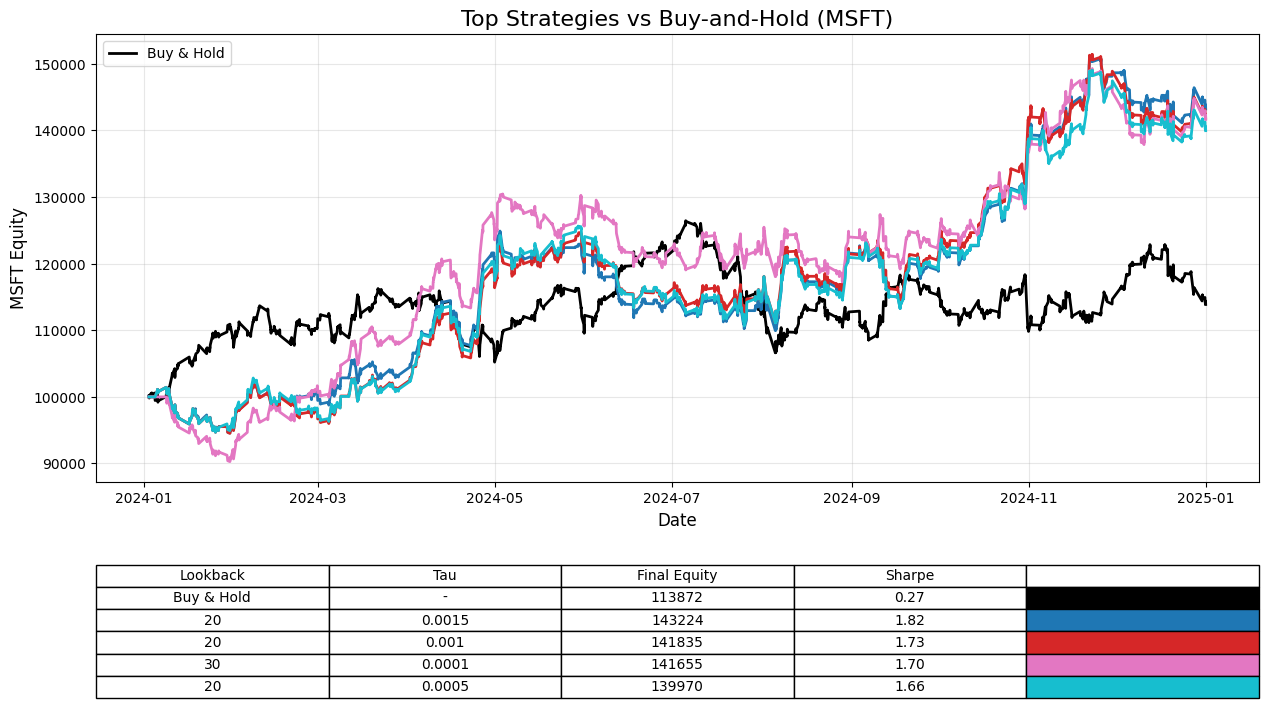

In [142]:
plot_top_strategies_with_table(
    df_bt=df_bt_msft,
    grid_results=grid_results_msft,
    all_equity_curves=all_equity_curves,
    ticker="MSFT",
    top_n=4
)


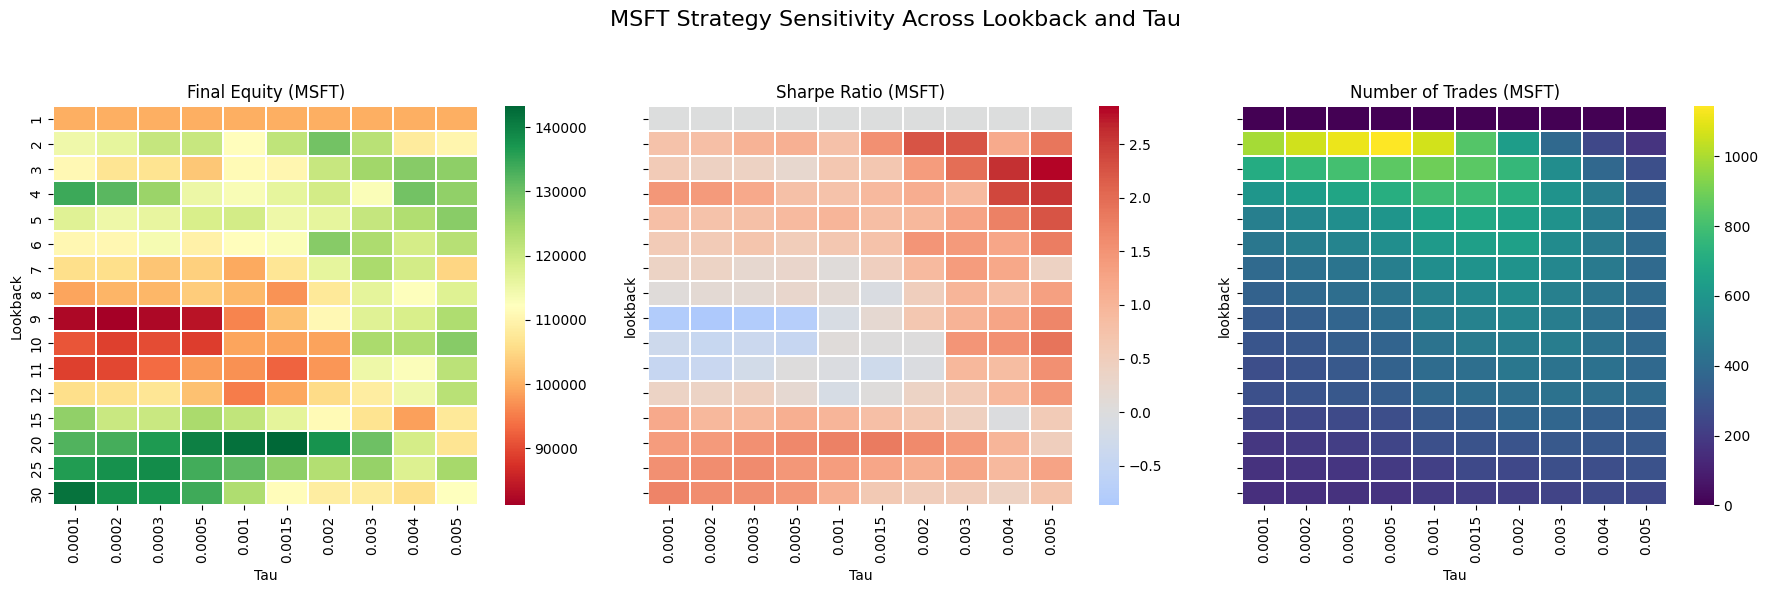

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot data (MSFT)
equity_map_msft = grid_results_msft.pivot(
    index="lookback", columns="tau", values="final_equity"
)

sharpe_map_msft = grid_results_msft.pivot(
    index="lookback", columns="tau", values="sharpe_ratio"
)

trades_map_msft = grid_results_msft.pivot(
    index="lookback", columns="tau", values="num_trades"
)

# Create subplots
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    sharey=True
)

# --- Final Equity ---
sns.heatmap(
    equity_map_msft,
    ax=axes[0],
    cmap="RdYlGn",
    linewidths=0.3,
    cbar=True
)
axes[0].set_title("Final Equity (MSFT)")
axes[0].set_xlabel("Tau")
axes[0].set_ylabel("Lookback")

# --- Sharpe Ratio ---
sns.heatmap(
    sharpe_map_msft,
    ax=axes[1],
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar=True
)
axes[1].set_title("Sharpe Ratio (MSFT)")
axes[1].set_xlabel("Tau")

# --- Number of Trades ---
sns.heatmap(
    trades_map_msft,
    ax=axes[2],
    cmap="viridis",
    linewidths=0.3,
    cbar=True
)
axes[2].set_title("Number of Trades (MSFT)")
axes[2].set_xlabel("Tau")

plt.suptitle("MSFT Strategy Sensitivity Across Lookback and Tau", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


# Would this strategy apply similarly to another equity like AMZN?

In [145]:
results_list = []
all_equity_curves_amzn = {}

df_bt_amzn = None  # store buy & hold once

for lb in lookbacks:
    for tau in taus:
        name = f"LB={lb}_TAU={tau}"

        strategy = BuyLowSellHighStrategy(
            lookback=lb,
            pct_threshold=tau
        )
        signals = strategy.generate_signals(amzn_df)

        bt = Backtester(signals)
        res = bt.run()

        df_bt = res["df"]

        # Save buy & hold ONCE
        if df_bt_amzn is None:
            df_bt_amzn = df_bt.copy()

        all_equity_curves_amzn[name] = df_bt[["Datetime", "equity"]]

        results_list.append({
            "lookback": lb,
            "tau": tau,
            "final_equity": res["final_equity"],
            "sharpe_ratio": res["sharpe_ratio"],
            "max_drawdown": res["max_drawdown"],
            "num_trades": res["trade_stats"]["num_trades"]
        })

grid_results_amzn = pd.DataFrame(results_list)


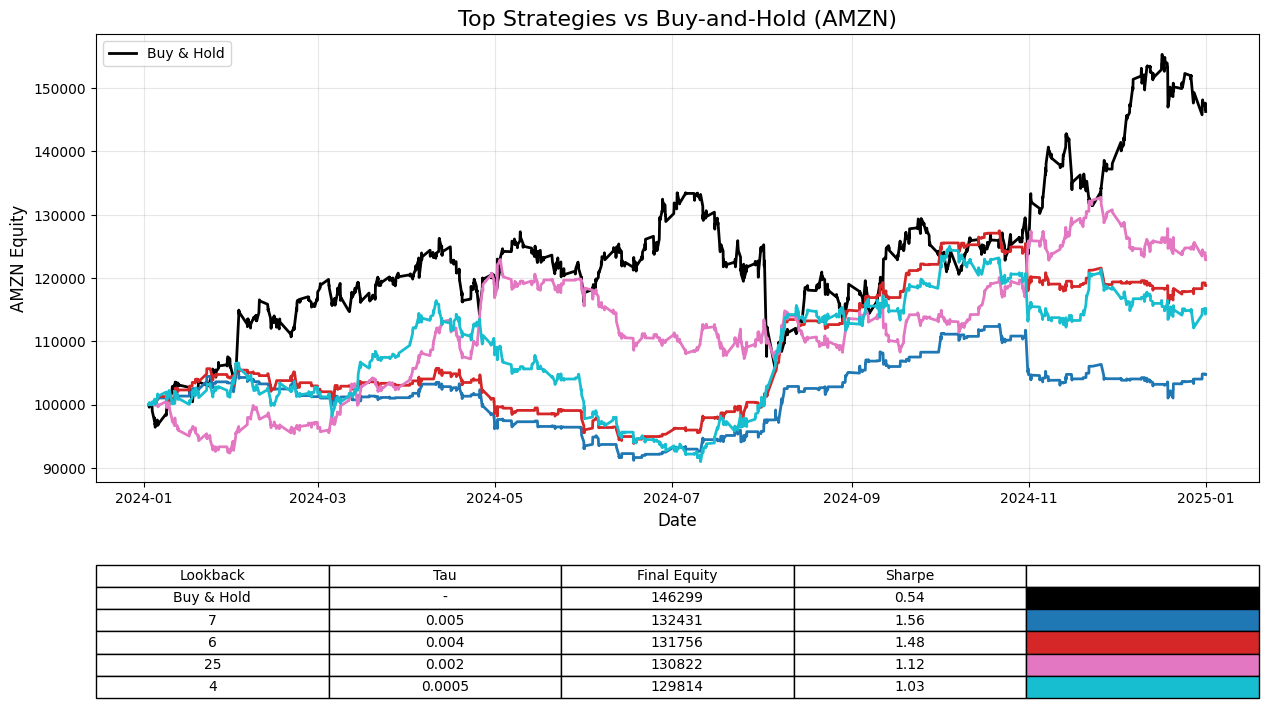

In [146]:
plot_top_strategies_with_table(
    df_bt=df_bt_amzn,
    grid_results=grid_results_amzn,
    all_equity_curves=all_equity_curves,
    ticker="AMZN",
    top_n=4
)


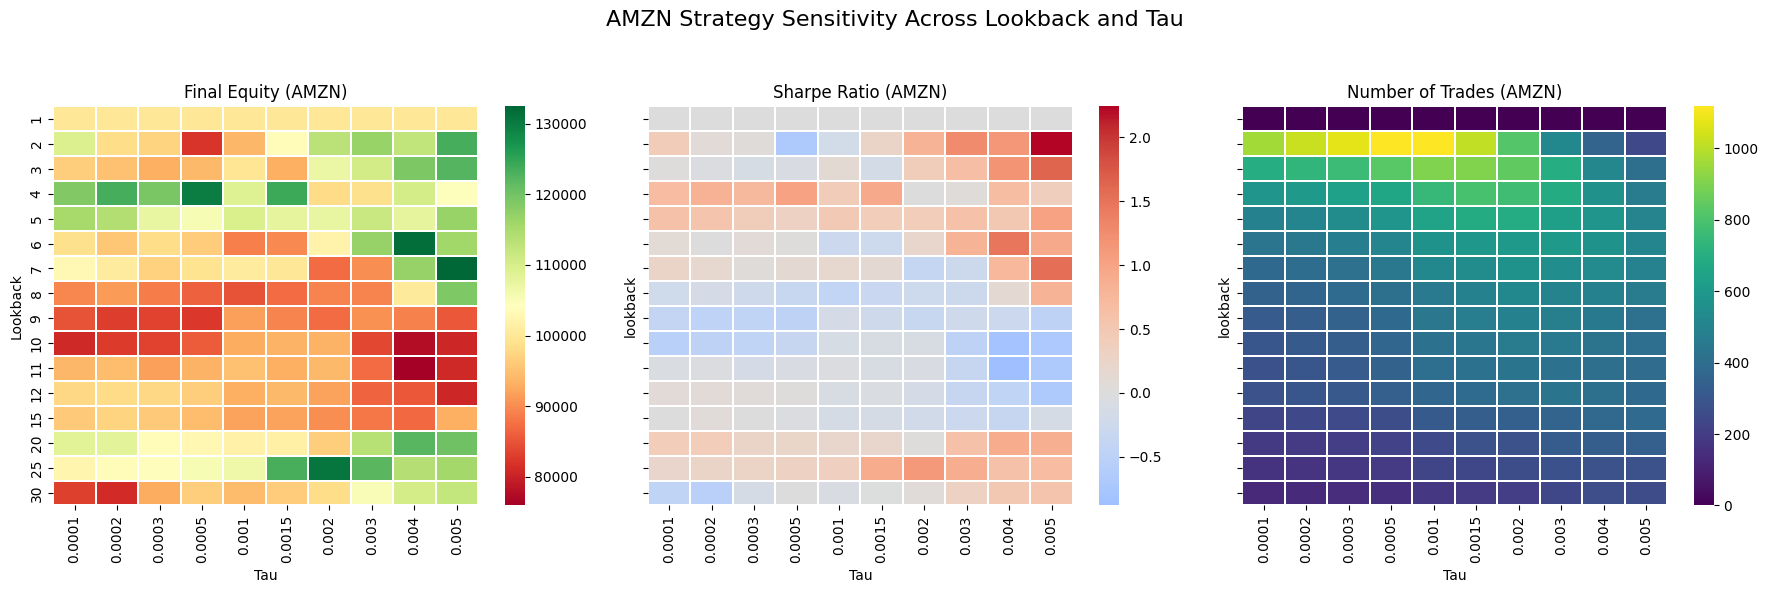

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot data (AMZN)
equity_map_amzn = grid_results_amzn.pivot(
    index="lookback", columns="tau", values="final_equity"
)

sharpe_map_amzn = grid_results_amzn.pivot(
    index="lookback", columns="tau", values="sharpe_ratio"
)

trades_map_amzn = grid_results_amzn.pivot(
    index="lookback", columns="tau", values="num_trades"
)

# Create subplots
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    sharey=True
)

# --- Final Equity ---
sns.heatmap(
    equity_map_amzn,
    ax=axes[0],
    cmap="RdYlGn",
    linewidths=0.3,
    cbar=True
)
axes[0].set_title("Final Equity (AMZN)")
axes[0].set_xlabel("Tau")
axes[0].set_ylabel("Lookback")

# --- Sharpe Ratio ---
sns.heatmap(
    sharpe_map_amzn,
    ax=axes[1],
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar=True
)
axes[1].set_title("Sharpe Ratio (AMZN)")
axes[1].set_xlabel("Tau")

# --- Number of Trades ---
sns.heatmap(
    trades_map_amzn,
    ax=axes[2],
    cmap="viridis",
    linewidths=0.3,
    cbar=True
)
axes[2].set_title("Number of Trades (AMZN)")
axes[2].set_xlabel("Tau")

plt.suptitle("AMZN Strategy Sensitivity Across Lookback and Tau", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


## Conclusion

The results show that the optimal strategy parameters (lookback window and deviation threshold τ) are not consistent across different stocks. While the same mean-reversion logic is applied, each asset exhibits distinct intraday volatility and price dynamics, leading to different regions of strong performance in the parameter space.

Rather than a single universally optimal parameter choice, the heatmaps reveal asset-specific regions where performance is relatively robust. Small changes in parameters can significantly affect returns, especially for short-horizon strategies, highlighting the sensitivity of intraday trading rules.

This suggests that parameter selection should be adaptive to the underlying asset, for example by scaling thresholds with volatility, rather than fixed across all stocks. Overall, the analysis emphasizes robustness and asset-specific calibration over searching for a single optimal parameter configuration.
